## PART II - Analogy Prediction 

Given a pair of words < 𝑎, 𝑏 > and a third word 𝑐, choose a fourth word 𝑑 so that the analogy **“𝑎 is to 𝑏 as 𝑐 is to 𝑑” holds**

the
relationship between 𝑐 and 𝑑 should be as close as possible to that between 𝑎 and 𝑏


In [1]:
#importing all libraries

import pandas as pd
from nltk.corpus import stopwords
import pandas as pd
import re
import nltk
from gensim.models import KeyedVectors
import gensim.downloader as g

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


#### ** The dataset is downloaded from : http://www.fit.vutbr.cz/ ̃imikolov/rnnlm/word-test.v1.txt

AND  only a subset of data is used, because it was taking more than 3 hours on my machine to give results 

## 2.1 Using glove & word2vec

In [2]:

#load w2v model 
word2vec_path = 'GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# load the GloVe model
modelglove = g.load("glove-wiki-gigaword-100")



# selected categories
selected_categories = [
    'capital-world', 
    'currency', 
    'city-in-state', 
    'family', 
    'gram1-adjective-to-adverb', 
    'gram2-opposite',
    'gram3-comparative', 
    'gram6-nationality-adjective'
]

#### Select specified categories from the dataset
Then in each category, find(process) each analogy row 

In [3]:
def process_category(file, category, model):
    total, num_correct = 0, 0
    found = False  # category found ? 
    
    for line in file:
        curRow = line.strip()

        if curRow.startswith(':'):  # check for category
            if curRow[2:] == category:  
                found = True  # found the desired category
                
            elif found:  # break when past the desired category
                break

        elif found:  # process analogy rows
            correct, valid = process_analogy_row(curRow, model)  # pass model here
            if valid:
                total += 1
                num_correct += correct

    return num_correct, total


def process_analogy_row(row, model):
    split = row.split()  # split into words
    if len(split) != 4:  # must have exactly 4 words
        return 0, False  

    # lowercase-- else glove will not be able to give results
    a, b, c, d = map(str.lower, split)

    # all 4 words in model's vocabulary
    if all(word in model for word in [a, b, c]):
        predicted_word = model.most_similar(positive=[b, c], negative=[a], topn=1)[0][0]
        return (predicted_word == d.lower()), True  
    else:
        return 0, False



#### Prints the Accuracy using the both models

In [4]:

def print_accuracy(category, num_correct, total):
    if total > 0:
        accuracy = num_correct / total
        print(f"Accuracy for {category}:{accuracy:.2f}")

        
        
def evaluate_selected_categories(file, selected_categories, model):
    for category in selected_categories:
        num_correct, total = process_category(file, category, model)  # Pass model here
        print_accuracy(category, num_correct, total)


#### glove results

In [5]:
#Glove results 
evaluate_selected_categories(file, selected_categories, modelglove)  

#### w2v results

In [6]:
evaluate_selected_categories(file, selected_categories, model)

##Comparing Accuracy of w2v and glove

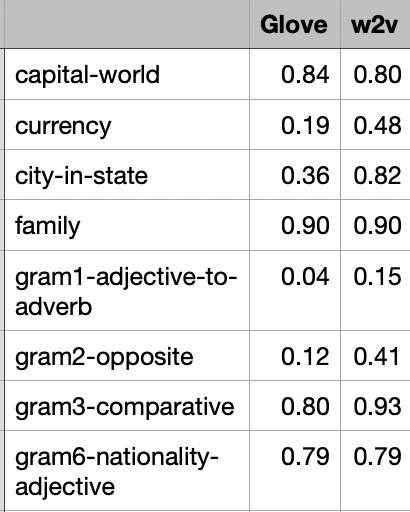

## 2.2 Antonyms

In [7]:
# top similar words for each antonym
antonyms = ['increase', 'enter' ]

def antonyms_embedding(model, antonyms):
    for word in antonyms:
        print(f"top 10 words similar to '{word}'")
        similar_words = model.most_similar(word, topn=10)
        for s, slarity in similar_words:
            print(f" - {s} (similarity: {slarity:.2f}")

In [8]:
print("glove results:")
antonyms_embedding(modelglove, antonyms)

glove results:
top 10 words similar to 'increase'
 - increased (similarity: 0.90
 - increases (similarity: 0.88
 - decrease (similarity: 0.88
 - increasing (similarity: 0.85
 - reduce (similarity: 0.81
 - rise (similarity: 0.79
 - reduced (similarity: 0.78
 - growth (similarity: 0.78
 - reduction (similarity: 0.78
 - boost (similarity: 0.78
top 10 words similar to 'enter'
 - entering (similarity: 0.78
 - leave (similarity: 0.72
 - join (similarity: 0.71
 - go (similarity: 0.70
 - able (similarity: 0.70
 - return (similarity: 0.70
 - entered (similarity: 0.70
 - allow (similarity: 0.69
 - take (similarity: 0.69
 - participate (similarity: 0.69


In [9]:
print("w2v results:")
antonyms_embedding(model, antonyms)

w2v results:
top 10 words similar to 'increase'
 - decrease (similarity: 0.84
 - increases (similarity: 0.77
 - increased (similarity: 0.76
 - reduction (similarity: 0.69
 - increasing (similarity: 0.69
 - decreases (similarity: 0.68
 - rise (similarity: 0.64
 - decreasing (similarity: 0.62
 - decline (similarity: 0.61
 - increasein (similarity: 0.60
top 10 words similar to 'enter'
 - entering (similarity: 0.74
 - entered (similarity: 0.70
 - reenter (similarity: 0.65
 - enters (similarity: 0.56
 - entry (similarity: 0.55
 - Entering (similarity: 0.48
 - participate (similarity: 0.48
 - leave (similarity: 0.48
 - join (similarity: 0.47
 - register (similarity: 0.46


#### why do embeddings have these tendency? 
1- Training Goal : We usually focus on training the model for predicting the similar words, rather than antonyms.

2- Polysemy (Same word, multiple related meanings)
Example: The term "cold" in a clinical setting. It could refer to a common viral infection (common cold).
It might also describe the temperature sensation (the patient feels
cold)

3- Synonymy (Different words with similar meanings): Terms like "myocardial infarction," "heart attack," and "cardiac
arrest."

4- Training Data :  text corpus used for training the embeddings can also impact the results.

* Taken from slides 

### 2.3 OPTIONAL SECTION - Analogy Tests 

## w2v 

In [10]:
def custom_analogy_test(modeltype, num_tests=5):
    correct_pred = 0
    
    data = [
        ("bitter", "sweet", "heavy", "light"),        
        ("happy", "sad", "rich", "poor"),    
        ("king", "man", "queen", "woman"),        
        ("petal", "flower", "drop", "ocean"),    
        ("director", "film", "chef", "food")
        
    ]

    for i in range(num_tests):
        a, b, c, correct_ans = data[i]

        # Check if the words are in the model's vocabulary
        if a in modeltype and b in modeltype and c in modeltype:
            
            res = modeltype.most_similar(positive=[b, c], negative=[a], topn=1)
            pred = res[0][0]
            print(f"predicted word ({a}, {b}, {c}): {pred}")

            if pred == correct_ans:
                correct_pred += 1

    # Calculate and print accuracy
    accuracy = correct_pred / num_tests * 100
    print(" ")
    print(f"accuracy: {accuracy:.2f}%")


In [11]:
#glove
custom_analogy_test(modelglove)

predicted word (bitter, sweet, heavy): light
predicted word (happy, sad, rich): impoverished
predicted word (king, man, queen): woman
predicted word (petal, flower, drop): fall
predicted word (director, film, chef): chefs
 
accuracy: 40.00%


In [12]:
#w2v
custom_analogy_test(model)

predicted word (bitter, sweet, heavy): Heavy
predicted word (happy, sad, rich): Melamine_nitrogen
predicted word (king, man, queen): woman
predicted word (petal, flower, drop): decline
predicted word (director, film, chef): movie
 
accuracy: 20.00%


## results  - glove performs better than the w2v model why? 

1) glove learns words in a large context and understands how words are related to each other ( co occurence ) . w2v sees only a limited context. 

2) glove captures relationships from the entire corpus.  w2v might struggle with rare words

3) the only drawback of glove is that it is memory intensive whereas w2v is scalable and efficient. 



## Citations
1) glove : Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. [pdf] [bib]

2)  Word2vec [Mikolov et al., 2013]: https://code.google.com/archive/p/word2vec/

3) GloVe [Pennington et al., 2014]: http://nlp.stanford.edu/projects/glove/

4) Dataset :  was downloaded from: http://www.fit.vutbr.cz/ ̃imikolov/rnnlm/word-test.v1.txt


In [13]:
import gensim
from gensim.models import KeyedVectors

# Load the Word2Vec model
word2vec_path = 'GoogleNews-vectors-negative300.bin'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Load GloVe model from text file
glove_file_path = 'glove.6B.300d.txt'  # Update this path based on your downloaded file
glove_model = KeyedVectors.load_word2vec_format(glove_file_path, binary=False)
import gensim
from gensim.models import KeyedVectors

# Load the Word2Vec model
word2vec_path = 'GoogleNews-vectors-negative300.bin'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Load GloVe model from text file
glove_file_path = 'glove.6B.300d.txt'  # Path to the GloVe embeddings
glove_model = KeyedVectors.load_word2vec_format(glove_file_path, binary=False)

# Selected categories
selected_categories = [
    'capital-world', 
    'currency', 
    'city-in-state', 
    'family', 
    'gram1-adjective-to-adverb', 
    'gram2-opposite',
    'gram3-comparative', 
    'gram6-nationality-adjective'
]

def process_category(file, category, model):
    total, num_correct = 0, 0
    found = False  # category found? 
    
    for line in file:
        curRow = line.strip()

        if curRow.startswith(':'):  # check for category
            if curRow[2:] == category:  
                found = True  # found the desired category
                
            elif found:  # break when past the desired category
                break

        elif found:  # process analogy rows
            correct, valid = process_analogy_row(curRow, model)  # pass model here
            if valid:
                total += 1
                num_correct += correct

    return num_correct, total

def process_analogy_row(row, model):
    split = row.split()  # split into words
    if len(split) != 4:  # must have exactly 4 words
        return 0, False  

    # lowercase-- else glove will not be able to give results
    a, b, c, d = map(str.lower, split)

    # all 4 words in model's vocabulary
    if all(word in model for word in [a, b, c]):
        predicted_word = model.most_similar(positive=[b, c], negative=[a], topn=1)[0][0]
        return (predicted_word == d.lower()), True  
    else:
        return 0, False

def print_accuracy(category, num_correct, total):
    if total > 0:
        accuracy = num_correct / total
        print(f"Accuracy for {category}: {accuracy:.2f}")

def evaluate_selected_categories(file, selected_categories, model):
    for category in selected_categories:
        num_correct, total = process_category(file, category, model)  # Pass model here
        print_accuracy(category, num_correct, total)

# Load analogy dataset from a URL or local file
analogy_dataset_url = 'https://raw.githubusercontent.com/nicholas-leonard/word2vec/master/questions-words.txt'
response = requests.get(analogy_dataset_url)
analogy_lines = response.text.splitlines()

# Run the evaluation for Word2Vec
print("Evaluating Word2Vec Model:")
evaluate_selected_categories(analogy_lines, selected_categories, word2vec_model)

# Run the evaluation for GloVe
print("\nEvaluating GloVe Model:")
evaluate_selected_categories(analogy_lines, selected_categories, glove_model)


ValueError: invalid literal for int() with base 10: 'the'